<a href="https://colab.research.google.com/github/BergmannJustin/Image_Classification_Pr-fung/blob/main/Image_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
import random

#Loading CIFAR-100 dataset

In [2]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

169001437/169001437 [==============================] - 6s 0us/step


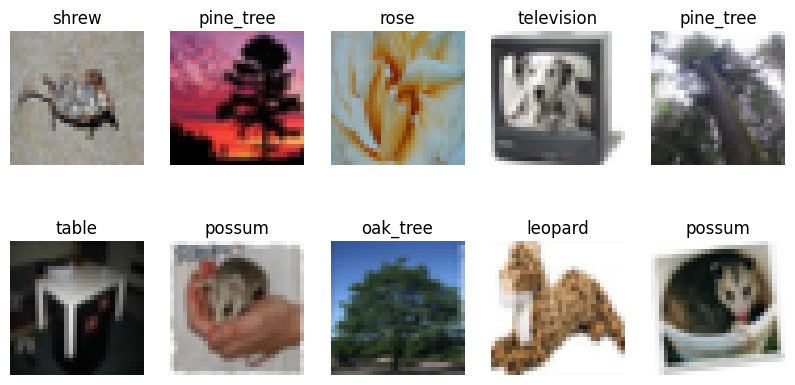

In [3]:
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea',
    'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower',
    'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle',
    'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

plt.figure(figsize=(10, 5))
start_index = 20  # Startindex für die Auswahl der Bilder
num_images = 10   # Anzahl der Bilder, die angezeigt werden sollen

for i in range(start_index, start_index + num_images):
    plt.subplot(2, 5, i - start_index + 1)
    plt.imshow(x_train[i])
    plt.title(class_names[int(y_train[i][0])])
    plt.axis('off')

In [4]:
# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

###Adding augmentation

In [5]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen.fit(x_train)

In [6]:
# Convert class vectors to binary class matrices
num_classes = 100
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

#Building Model Architecture

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense, Dropout, Input

In [8]:
def resnet_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    shortcut = x
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [9]:
def transformer_block(x, num_heads, ff_dim, dropout_rate=0.1, filters=64):
    # Multi-Head Attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=64)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    attn_output = layers.add([attn_output, x])
    attn_output = LayerNormalization(epsilon=1e-6)(attn_output)

    # Feedforward Network
    ffn_output = layers.Conv2D(ff_dim, 1, activation='relu')(attn_output)
    ffn_output = layers.Conv2D(filters, 1, activation='relu')(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    ffn_output = layers.add([ffn_output, attn_output])
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output)

    return ffn_output

In [10]:
def modified_complex_net_with_transformer_and_resnet(input_shape=(256, 256, 3), num_classes=100, num_resnet_blocks=3, num_blocks_list=[2, 2, 2, 2], dropout_rate=0.5):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    x = layers.Conv2D(64, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Adding Transformer block after the first set of convolutions
    x = transformer_block(x, num_heads=2, ff_dim=64, dropout_rate=0.1)

    # Adding additional ResNet blocks
    for _ in range(num_resnet_blocks):
        x = resnet_block(x, 64)

    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            strides = 2 if i > 0 and j == 0 else 1
            x = resnet_block(x, 64 * 2**i, stride=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model

In [11]:
input_shape = x_train.shape[1:]
model = modified_complex_net_with_transformer_and_resnet(input_shape, num_classes)


###Compiling the model

In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


###Displaing model summary

In [13]:
model_with_transformer_and_resnet_extended = modified_complex_net_with_transformer_and_resnet(input_shape=(256, 256, 3), num_classes=100, num_resnet_blocks=5, num_blocks_list=[3, 4, 6, 3], dropout_rate=0.5)
model_with_transformer_and_resnet_extended.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_37 (Conv2D)          (None, 128, 128, 64)         9472      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_35 (Ba  (None, 128, 128, 64)         256       ['conv2d_37[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_24 (Activation)  (None, 128, 128, 64)         0         ['batch_normalization_35

#Training the model

In [16]:
epochs = 50
batch_size = 64
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs)

Epoch 1/50
782/782 [==============================] - 50s 64ms/step - loss: 2.5953 - accuracy: 0.3385
Epoch 2/50
782/782 [==============================] - 50s 64ms/step - loss: 2.5300 - accuracy: 0.3480
Epoch 3/50
782/782 [==============================] - 50s 64ms/step - loss: 2.5192 - accuracy: 0.3528
Epoch 4/50
782/782 [==============================] - 50s 64ms/step - loss: 2.6350 - accuracy: 0.3292
Epoch 5/50
782/782 [==============================] - 50s 64ms/step - loss: 2.5094 - accuracy: 0.3536
Epoch 6/50
782/782 [==============================] - 50s 64ms/step - loss: 2.5110 - accuracy: 0.3549
Epoch 7/50
782/782 [==============================] - 51s 65ms/step - loss: 2.5047 - accuracy: 0.3563
Epoch 8/50
782/782 [==============================] - 50s 64ms/step - loss: 2.5288 - accuracy: 0.3493
Epoch 9/50
782/782 [==============================] - 49s 63ms/step - loss: 2.4186 - accuracy: 0.3739
Epoch 10/50
782/782 [==============================] - 49s 63ms/step - loss: 2.377

###Training for 20 more epoches

In [17]:
model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=20)

Epoch 1/20
782/782 [==============================] - 50s 63ms/step - loss: 2.0549 - accuracy: 0.4542
Epoch 2/20
782/782 [==============================] - 50s 64ms/step - loss: 2.0580 - accuracy: 0.4522
Epoch 3/20
782/782 [==============================] - 50s 64ms/step - loss: 2.1614 - accuracy: 0.4326
Epoch 4/20
782/782 [==============================] - 49s 63ms/step - loss: 2.0092 - accuracy: 0.4629
Epoch 5/20
782/782 [==============================] - 50s 64ms/step - loss: 1.9874 - accuracy: 0.4699
Epoch 6/20
782/782 [==============================] - 50s 64ms/step - loss: 1.9956 - accuracy: 0.4659
Epoch 7/20
782/782 [==============================] - 50s 64ms/step - loss: 2.0901 - accuracy: 0.4475
Epoch 8/20
782/782 [==============================] - 50s 64ms/step - loss: 2.1009 - accuracy: 0.4448
Epoch 9/20
782/782 [==============================] - 51s 65ms/step - loss: 2.0034 - accuracy: 0.4657
Epoch 10/20
782/782 [==============================] - 50s 64ms/step - loss: 2.027

#Visualizing learning curve of model

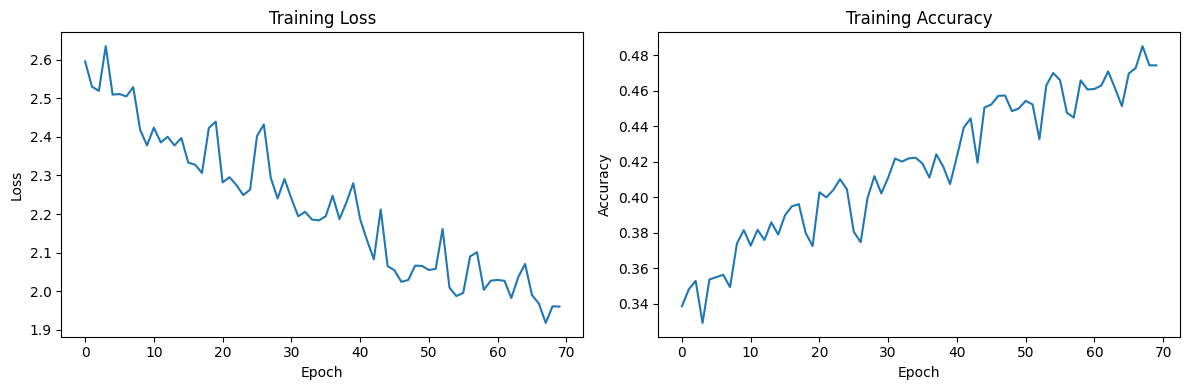

In [18]:
history2 = {
    'loss': [2.0549, 2.0580, 2.1614, 2.0092, 1.9874, 1.9956, 2.0901, 2.1009, 2.0034, 2.0273, 2.0292, 2.0269, 1.9824, 2.0362, 2.0706, 1.9901, 1.9681, 1.9179, 1.9609, 1.9601],
    'accuracy': [0.4542, 0.4522, 0.4326, 0.4629, 0.4699, 0.4659, 0.4475, 0.4448, 0.4657, 0.4606, 0.4609, 0.4628, 0.4708, 0.4613, 0.4512, 0.4696, 0.4727, 0.4850, 0.4742, 0.4742]
}


# Concatenate the history data
combined_history = {
    'loss': history.history['loss'] + history2['loss'],
    'accuracy': history.history['accuracy'] + history2['accuracy']
}

# Plot loss vs epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(combined_history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy vs epoch
plt.subplot(1, 2, 2)
plt.plot(combined_history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

#Printing Test Accuracy

In [19]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

print(f'Test Accuracy: {test_accuracy*100:.2f}%')

313/313 - 4s - loss: 2.9043 - accuracy: 0.3315 - 4s/epoch - 12ms/step
Test Accuracy: 33.15%


#Saving the model

In [23]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [24]:
model.save('/content/gdrive/My Drive/CIFAR_100_NN_Model.h5')
model_json = model.to_json()
with open('my_model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

# Save model weights to HDF5 file
model.save_weights('my_model_weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
!ls '/content/gdrive/My Drive/CIFAR_100_NN_Model.h5'

'/content/gdrive/My Drive/CIFAR_100_NN_Model.h5'


#Making Predictions


In [26]:
predictions = model.predict(x_test)

313/313 [==============================] - 3s 8ms/step


### Predicted and actual classes

1/1 [==============================] - 0s 21ms/step


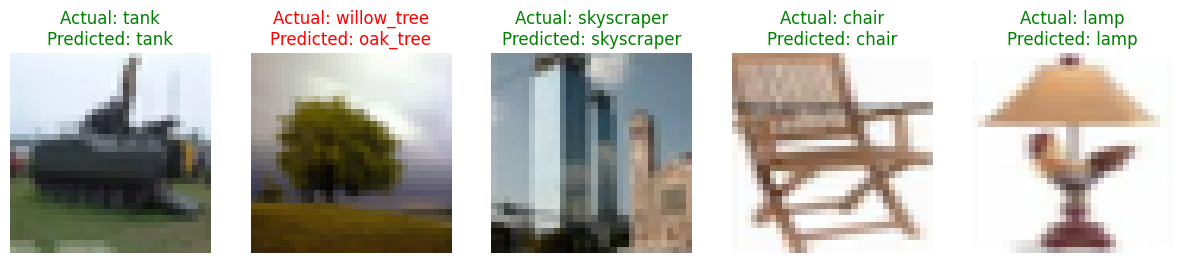

In [33]:
# Choose 10 random indices
random_indices = random.sample(range(len(x_test)), 5)

# Make predictions on the selected random test data
selected_x_test = x_test[random_indices]
selected_y_test = y_test[random_indices]
selected_predictions = model.predict(selected_x_test)

# Display the randomly selected test images along with their predicted and actual classes
plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx])

    actual_class = int(np.argmax(selected_y_test[i]))  # Assuming y_test is one-hot encoded
    predicted_class = int(np.argmax(selected_predictions[i]))

    # Check if the prediction is correct
    text_color = 'green' if actual_class == predicted_class else 'red'

    plt.title(f'Actual: {class_names[actual_class]}\nPredicted: {class_names[predicted_class]}', color=text_color)
    plt.axis('off')

plt.show()